# Lithology facies Machine Learning Classification: Using SMOTE, GridSearch, and Ensemble.


# **Introduction and Setup**

This notebook explores a dataset related to facies classification in well logs. Facies, representing different rock types, are crucial for understanding subsurface geology and reservoir characterization. The goal is to build a machine learning model capable of accurately predicting facies from well log data.

The labeled well log data are from real wells of Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.

There are totally seven features for each well log:

gamma ray (GR)

resistivity logging (ILD_log10)

photoelectric effect (PE)

neutron-density porosity difference
average neutron-density porosity (DeltaPHI and PHIND)

nonmarine-marine indicator (NM_M)

and relative position (RELPOS)

![image.png](attachment:43f7895a-d879-424e-811a-fbf469c75f57.png)


We begin by importing the necessary libraries for data manipulation, visualization, and machine learning.


# Importing the necessary libraries

In [ ]:
# for DataFrame operation
import numpy as np
import pandas as pd

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for preprocessing
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# for ML modeling
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

#for Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## 1. Data Loading and Initial Inspection

Next, we load the dataset from a Google Drive URL. for more generalized approach.

In [ ]:
# Load the dataset (Google Drive)
url = 'https://drive.google.com/file/d/19UU1UL6J-VfnV29AQoVlpWaqoVOdywPO/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]


data = pd.read_csv(path)


# --- Initial Data Inspection ---
print("--- Initial Data Inspection ---")
print(data.info())
print("\n--- Missing Values ---")
print(data.isnull().sum())
print("\n--- First 5 Rows ---")
print(data.head())

--- Initial Data Inspection ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB
None

--- Missing Values ---
Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

--- First 5 Rows ---
   Facies Formation  Well 

## 2. Exploratory Data Analysis (EDA)


## 2.1. Descriptive Statistics

In [ ]:
print(data.describe())

            Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean      4.503254  2906.867438    64.933985     0.659566     4.402484   
std       2.474324   133.300164    30.302530     0.252703     5.274947   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2821.500000    44.730000     0.498000     1.600000   
50%       4.000000  2932.500000    64.990000     0.639000     4.300000   
75%       6.000000  3007.000000    79.438000     0.822000     7.500000   
max       9.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  
count  4149.000000  3232.000000  4149.000000  4149.000000  
mean     13.201066     3.725014     1.518438     0.521852  
std       7.132846     0.896152     0.499720     0.286644  
min       0.550000     0.200000     1.000000     0.000000  
25%       8.500000     3.100000  

## 2.2. Class Distribution (Target Variable)

This is crucial to identify class imbalances. If some classes are significantly under-represented, it may be necessary to use techniques like SMOTE.



--- Class Distribution (Target Variable) ---
Facies
2    940
3    780
8    686
6    582
5    296
4    271
1    268
9    185
7    141
Name: count, dtype: int64


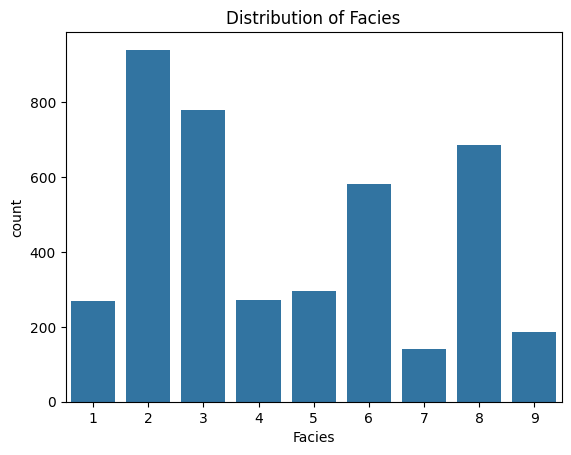

In [ ]:
print("\n--- Class Distribution (Target Variable) ---")
print(data['Facies'].value_counts())
sns.countplot(x='Facies', data=data)
plt.title('Distribution of Facies')
plt.show()

### observation
- The Facies have a great imbalance, can be remedied using SMOTE

## 2.3. Correlation Analysis

Look for highly correlated features, which might indicate multicollinearity.  This can impact the performance of some models.

In [ ]:
# Identifying categorical valuables
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [ ]:
# Drop 'Formation' and 'Well Name' columns
data = data.drop(columns=['Formation', 'Well Name'])


--- Correlation Analysis ---


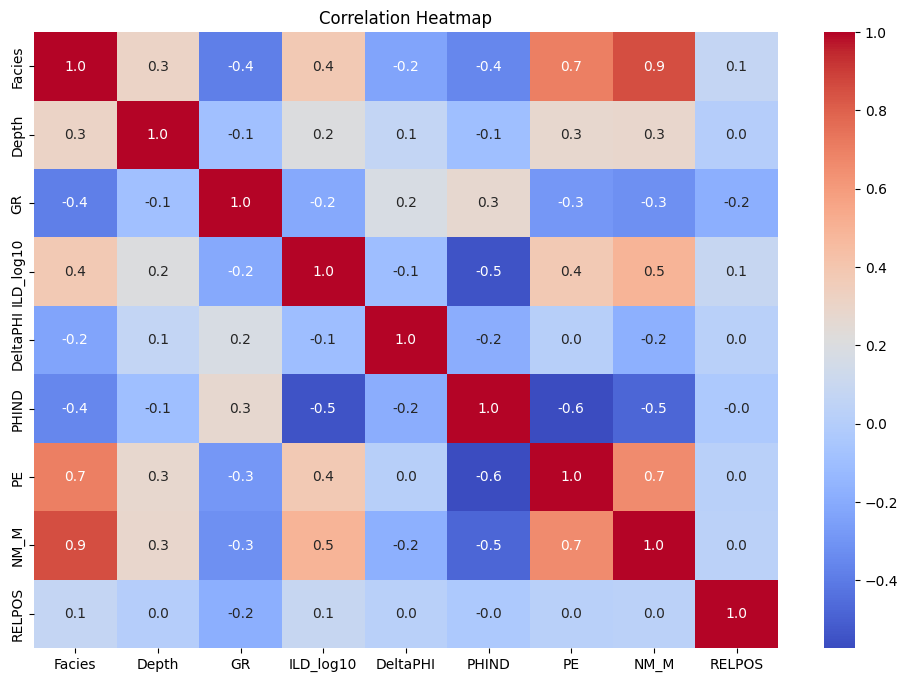

In [ ]:
print("\n--- Correlation Analysis ---")
plt.figure(figsize=(12, 8))  # Adjust figure size for better readability
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

## 2.4. Feature Distributions
This helps you understand the distribution of each feature, identify skewness, and potential outliers.



--- Feature Distributions ---


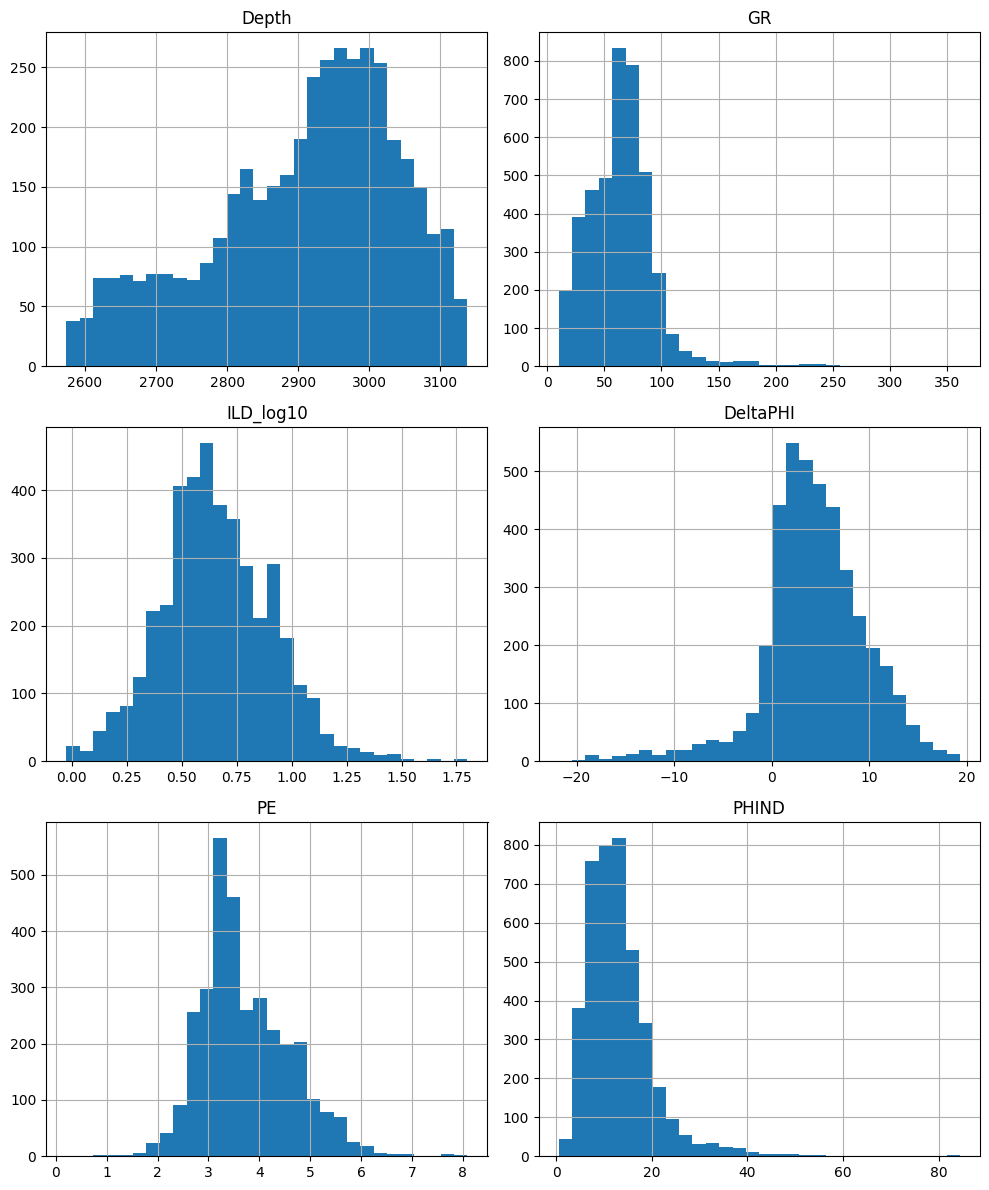

In [ ]:

# Histograms for numerical features
print("\n--- Feature Distributions ---")

Numerical=data[['Depth','GR','ILD_log10','DeltaPHI','PE','PHIND']]
Numerical.hist(figsize=(10, 12), bins=30)
plt.tight_layout()
plt.show()

### Observations:
- the mean of Gamma Ray logs lay between (60 and 80).
- the mean of photoelectric effect logs lay between (3 and 4).
- the mean of resistivity logs lay between (0.50 and 0.75).
- The depth in study is between 2600 to 3100 ft.

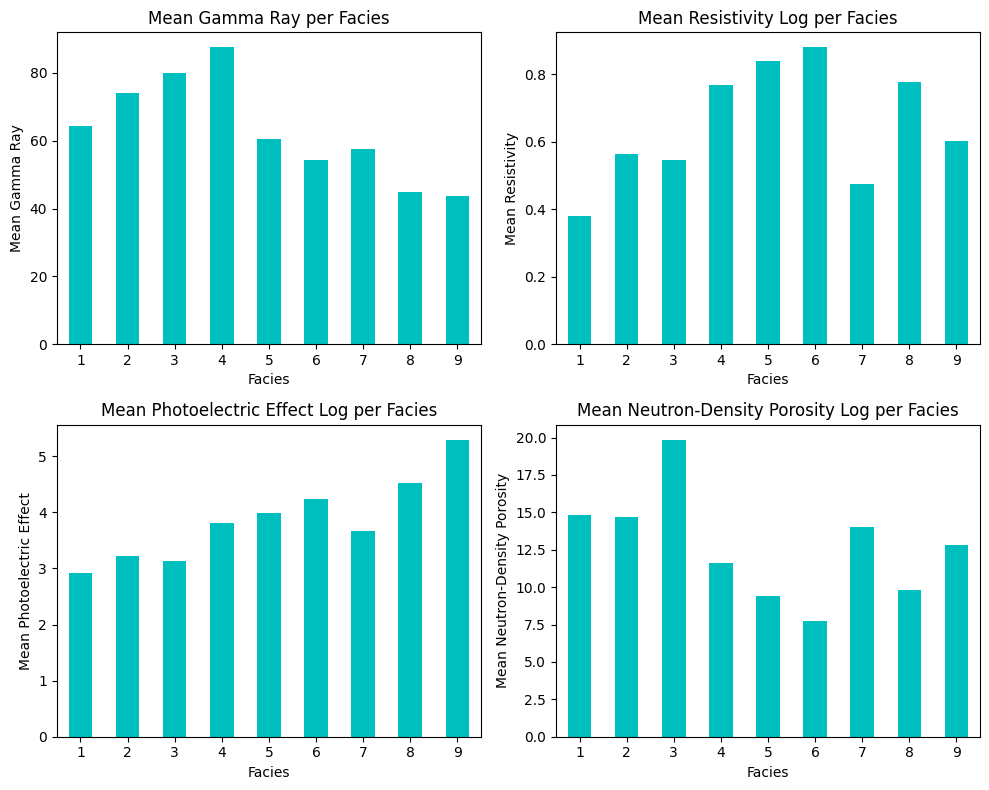

In [ ]:
# comparing Facies across diff Logs

logs = {
    'GR': ('Mean Gamma Ray', 'Mean Gamma Ray per Facies'),
    'ILD_log10': ('Mean Resistivity', 'Mean Resistivity Log per Facies'),
    'PE': ('Mean Photoelectric Effect', 'Mean Photoelectric Effect Log per Facies'),
    'PHIND': ('Mean Neutron-Density Porosity', 'Mean Neutron-Density Porosity Log per Facies')
}

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


axes = axes.flatten()


for i, (log_column, (ylabel, title)) in enumerate(logs.items()):
    log_per_facies = data.groupby('Facies')[log_column].mean()
    log_per_facies.plot(kind='bar', ax=axes[i], xlabel='Facies', ylabel=ylabel, title=title, color='c' )
    axes[i].tick_params(axis='x', rotation=0)

# Adjust layout and display

plt.tight_layout()
plt.show()

### Observations:
- Gamma Ray:
     - The highest content: face 4 (Marine Siltstone and Shale), which is predictable.
     - The lowest content: face 9 (Bafflestone).
       
- Restivity:

      - The highest content: face 6 (Mudstone).
      - The lowest content: face 1 (Nonmarine Sandstone)

- Photoelectric:

      - The highest content: face 9 (Bafflestone).
      - The lowest content: face 1 (Nonmarine Sandstone).

- Neutron-Density Porosity:

      - The highest content: face 3 (Nonmarine fine Siltstone).
      - The lowest content: face 6 (Mudstone).

## 3. Data Preprocessing


In [ ]:
# Handle missing values using KNN imputation
print("\n--- Handling missing values with KNN Imputation ---")
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)  # Apply to the entire dataset


--- Handling missing values with KNN Imputation ---


In [ ]:
# Convert back to a DataFrame
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
print(data_imputed.info())
print(data_imputed.isnull().sum())  # Verify that missing values are handled.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   float64
 1   Depth      4149 non-null   float64
 2   GR         4149 non-null   float64
 3   ILD_log10  4149 non-null   float64
 4   DeltaPHI   4149 non-null   float64
 5   PHIND      4149 non-null   float64
 6   PE         4149 non-null   float64
 7   NM_M       4149 non-null   float64
 8   RELPOS     4149 non-null   float64
dtypes: float64(9)
memory usage: 291.9 KB
None
Facies       0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64


In [ ]:
# Define features and target
features = ['Depth','GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
X = data_imputed[features]
y = data_imputed['Facies']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Handle imbalanced data using SMOTE

print("\n--- Handling imbalanced data using SMOTE ---")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


--- Handling imbalanced data using SMOTE ---


In [ ]:
# Standardize features

print("\n--- Standardizing features ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


--- Standardizing features ---


## 4. Model Training and Evaluation


In [ ]:
#  models

models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Log Reg': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier()
}

In [ ]:
# Hyperparameter tuning using GridSearchCV

param_grids = {
    'SVM': {
        'C': range(5,10),  # Regularization parameter
        'gamma': [0.01, 0.1 ,1],  # Kernel coefficient
        'kernel': ['rbf'],  # Kernel type
        'class_weight': ['balanced', None]  # class weighting to remedy class imbalance.
    },
    'KNN': {
        'n_neighbors': range(2,10,2),  # Number of neighbors (even values for odd categories, 9 facies)
        'weights': ['uniform', 'distance'],  # Weight function
        'algorithm': ['auto', 'ball_tree', 'kd_tree']  # Algorithm used to compute nearest neighbors
    },
    'Log Reg': {
        'C': [0.1,  10],  # Inverse of regularization strength
        'solver': ['lbfgs', 'liblinear']  # Optimization algorithm
    },
    'RF': {
        'n_estimators': [100, 500],  # Number of trees in the forest
        'max_depth': [ 10, 20],  # Maximum depth of the trees
        'criterion': ['gini', 'entropy']  # Splitting criterion
    }
}

In [ ]:
# GridSearchCV

for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_scaled, y_resampled)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_:.4f}\n")

Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 9, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score for SVM: 0.8902

Tuning hyperparameters for KNN...
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}
Best cross-validation score for KNN: 0.8898

Tuning hyperparameters for Log Reg...
Best parameters for Log Reg: {'C': 10, 'solver': 'lbfgs'}
Best cross-validation score for Log Reg: 0.5915

Tuning hyperparameters for RF...
Best parameters for RF: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 500}
Best cross-validation score for RF: 0.8924



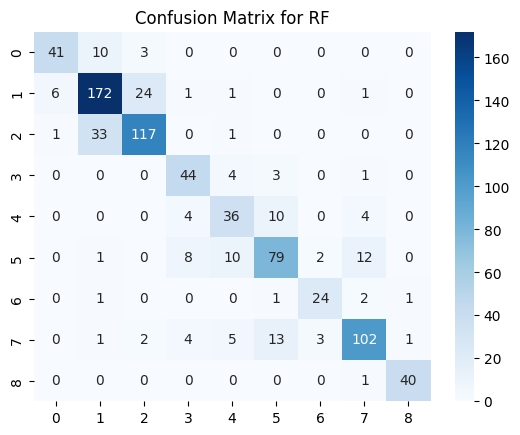

In [ ]:

best_model_name = 'RF'
best_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=20,
    n_estimators=500
)

best_model.fit(X_scaled, y_resampled)

y_pred = best_model.predict(X_test_scaled)

# confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


In [ ]:

# classification report

print(f"Classification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report for RF:

              precision    recall  f1-score   support

         1.0       0.85      0.76      0.80        54
         2.0       0.79      0.84      0.81       205
         3.0       0.80      0.77      0.79       152
         4.0       0.72      0.85      0.78        52
         5.0       0.63      0.67      0.65        54
         6.0       0.75      0.71      0.72       112
         7.0       0.83      0.83      0.83        29
         8.0       0.83      0.78      0.80       131
         9.0       0.95      0.98      0.96        41

    accuracy                           0.79       830
   macro avg       0.79      0.80      0.79       830
weighted avg       0.79      0.79      0.79       830



     Feature  Importance
6       NM_M    0.176947
1         GR    0.146638
0      Depth    0.138390
2  ILD_log10    0.126658
5         PE    0.119495
4      PHIND    0.109005
3   DeltaPHI    0.096390
7     RELPOS    0.086476


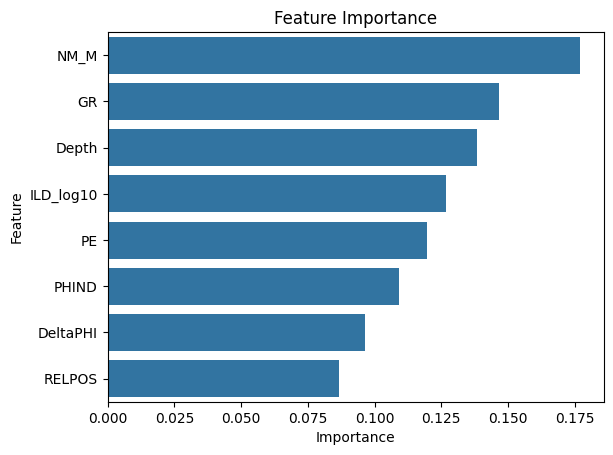

In [ ]:
# Feature importance
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

# plotting it for better visual

sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()